# Multi-Asset TOB Example

In this example we showcase a simple pairs trading strategy on one exchange. 

The strategy is based on the co-movement of two assets, UNI & SUSHI, and is heavily inspired by [this](https://github.com/jamesmawm/High-Frequency-Trading-Model-with-IB/blob/master/models/hft_model_1.py) model from James Ma. 

For it, we need two measures: 
- beta: $\beta = \frac{\mu_{SUSHI}}{\mu_{UNI}}$ where $\mu$ is the rolling average of the mid-price of an asset. The calculation used here is the one-pass EMA with a decay of 100. This beta between the two means is used to infer the mid-price of the SUSHI based on UNI. So $\overline{\text{SUSHI}} = \text{UNI} \times \beta$ where we have a trading decision.
- vol_ratio: $\gamma = \frac{\sigma_{SUSHI}}{\sigma_{UNI}}$

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange
from src.utils.one_pass_calculations import mean, var

%load_ext autoreload 
%autoreload 2

## Import data

In [2]:
folder_path = 'data_loader/datasets/'

In [3]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)
    return df

In [4]:
symbols = ['SUSHIUSDT', 'UNIUSDT']

trades_list = []
quotes_list = []

for symbol in symbols: 
    # define folder path
    quotes_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'quotes']
    
    trades_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'trades']

In [5]:
quotes = get_data(quotes_list)
trades = get_data(trades_list)

100%|██████████| 2/2 [00:00<00:00,  6.79it/s]


## Testing

In [6]:
from src.utils.one_pass_calculations import mean, var

In [7]:
lookback_us = 10*60 * 1_000_000

In [8]:
a_mean = mean(lookback_us)
a_var = var(lookback_us)

In [9]:
quotes_a = quotes[quotes.symbol == 'SUSHIUSDT'].copy()
quotes_b = quotes[quotes.symbol == 'UNIUSDT'].copy()

quotes_a['mid'] = (quotes_a.bid_price + quotes_a.ask_price) / 2
quotes_b['mid'] = (quotes_b.bid_price + quotes_b.ask_price) / 2

In [10]:
out = []
v_out = []

for i, r in tqdm(quotes_a.iterrows()):
    tmp_ema = a_mean.update(r['mid'], r['timestamp'])
    tmp_var = a_var.update(r['mid'], tmp_ema, r['timestamp'])
    out.append(tmp_ema)
    v_out.append(tmp_var)

quotes_a['ema'] = out
quotes_a['var'] = v_out
quotes_a['time'] = pd.to_datetime(quotes_a.timestamp, unit='us')
quotes_a.set_index('time', inplace=True)

0it [00:00, ?it/s]

284292it [00:05, 51414.62it/s]


In [11]:
quotes_a['ema'] = out
quotes_a['var'] = v_out

In [12]:
quotes_a['time'] = pd.to_datetime(quotes_a.timestamp, unit='us')
quotes_a.set_index('time', inplace=True)

<Axes: xlabel='time'>

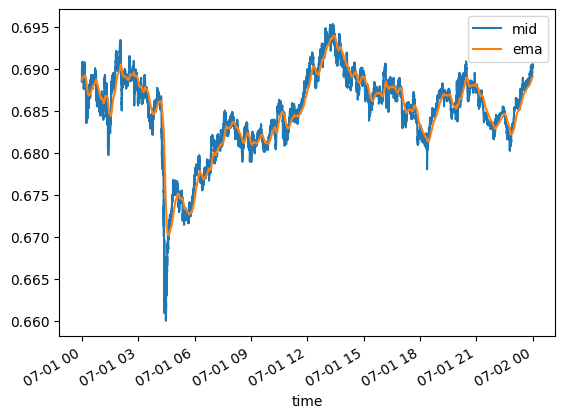

In [13]:
quotes_a[['mid', 'ema']].plot()

## Pred

In [14]:
halflife = 1_000
beta = np.exp(np.log(0.5) / halflife)

In [34]:
lr = ExpL2Regression(5, 0.1, halflife)

In [35]:
quotes['time'] = pd.to_datetime(quotes.timestamp, unit='us')
quotes['mid'] = (quotes.bid_price + quotes.ask_price) / 2
# quotes.set_index('time', inplace=True)

In [36]:
lr_test = pd.pivot_table(data=quotes[quotes.symbol == 'UNIUSDT'], values=['mid', 'ask_amount', 'ask_price','bid_price','bid_amount'], index='time').ffill()
# lr_test = pd.pivot_table(data=quotes, values='mid', index='time', columns='symbol').ffill()

In [37]:
test = pd.merge_asof(lr_test, quotes[quotes.symbol == 'SUSHIUSDT'][['mid', 'time']], left_index=True, right_index=False, right_on='time', direction='forward').dropna()

In [38]:
# lr_test = pd.pivot_table(data=quotes, values='mid', index='time', columns='symbol')
# lr_test.columns = ['X', 'Y']
X = ['mid_x', 'ask_amount', 'ask_price','bid_price','bid_amount']
y = ['mid_y']
lr_test = lr_test.dropna()

In [39]:
cutoff = int(len(test) * 0.8)
full_length = len(test)

In [40]:
preds = []

for i in tqdm(range(full_length-1)):
    lr.update(test.iloc[i][X].to_numpy(), test.iloc[i][y].to_numpy()[0])
    preds.append(lr.predict(test.iloc[i+1][X].to_numpy()))

  8%|▊         | 28086/362405 [00:12<02:27, 2265.82it/s]


KeyboardInterrupt: 

In [41]:
predictions = test.iloc[:i].copy()

In [42]:
predictions['pred'] = preds

In [43]:
predictions['error'] = predictions.pred - predictions.mid_y

<Axes: >

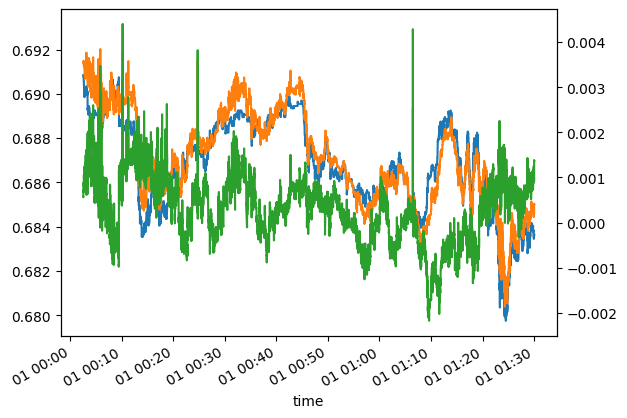

In [44]:
predictions.iloc[1_000:].mid_y.plot()
predictions.iloc[1_000:].pred.plot()
predictions.iloc[1_000:].error.plot(secondary_y=True)

<Axes: xlabel='time'>

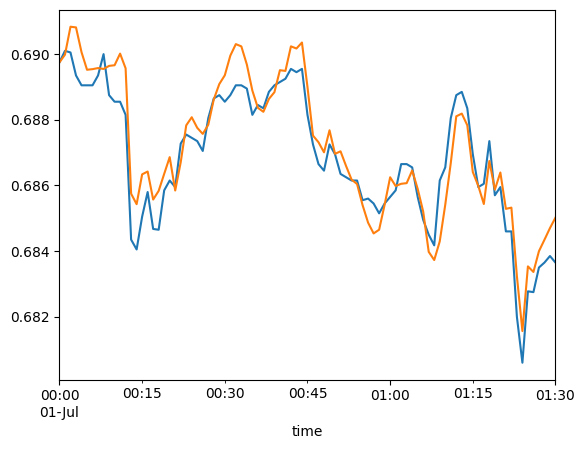

In [45]:
predictions.resample('1T').median().mid_y.plot()
predictions.resample('1T').median().pred.plot()

<Axes: >

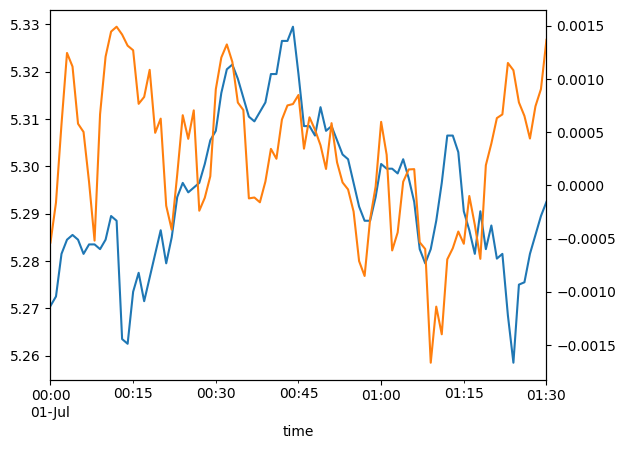

In [46]:
predictions.resample('1T').median().mid_x.plot()
predictions.resample('1T').median().error.plot(secondary_y=True)

## Prepare Exchange

In [6]:
binance = TOB_Exchange()

In [7]:
usd_amount = 10_000
prices = quotes.groupby('symbol').ask_price.max()

per_asset = usd_amount // prices

In [8]:
for symbol in symbols: 
    binance.add_market(symbol, symbol[:-4], symbol[-4:])
    binance.add_balance(symbol[:-4], per_asset[symbol])
    binance.add_balance(symbol[-4:], usd_amount)
    binance.load_tob(quotes.loc[quotes.symbol == symbol, ['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy(), symbol)
    binance.load_trades(trades.loc[trades.symbol == symbol, ['timestamp', 'id', 'side', 'price', 'amount']].to_numpy(), symbol)

2023-07-28 22:25:50,753 - INFO - src.exchange - Loading 284292 TOB-Updates for SUSHIUSDT
2023-07-28 22:25:51,731 - INFO - src.exchange - TOB-Updates loaded successfully
2023-07-28 22:25:51,773 - INFO - src.exchange - Loading 179322 trades for SUSHIUSDT
2023-07-28 22:25:52,205 - INFO - src.exchange - Trades loaded successfully
2023-07-28 22:25:52,251 - INFO - src.exchange - Loading 362406 TOB-Updates for UNIUSDT
2023-07-28 22:25:53,881 - INFO - src.exchange - TOB-Updates loaded successfully
2023-07-28 22:25:53,941 - INFO - src.exchange - Loading 297836 trades for UNIUSDT
2023-07-28 22:25:54,797 - INFO - src.exchange - Trades loaded successfully


In [9]:
class strategy:
    def __init__(self, exchange, symbols, lookback_mean, lookback_var) -> None:

        # Amonut of USDT that will be traded
        self.volume = 1_000

        self.information = {}
        self.symbols = symbols
        self.exchange = exchange

        self.warmup = 5_000

        self.indicators = []

        for symbol in symbols: 
            self.information[symbol] = {}
            self.information[symbol]['ema'] = mean(lookback_mean)
            self.information[symbol]['var'] = var(lookback_var, calculate_ema=True)
            self.information[symbol]['price'] = None

        self.position = 0
            
    def trading_indicators(self):
        if self.information[self.symbols[1]]['var'].var == 0:
            vol_ratio = 0
        else:
            vol_ratio = self.information[self.symbols[0]]['var'].var / self.information[self.symbols[1]]['var'].var
        self.trend = 1 if vol_ratio > 1 else 0
        beta = self.information[self.symbols[0]]['ema'].ema / self.information[self.symbols[1]]['ema'].ema
        impl_mid = self.information[self.symbols[1]]['price'] * beta
        self.under = 1 if impl_mid < self.information[self.symbols[0]]['price'] else 0
        return [vol_ratio, beta, impl_mid, self.trend, self.under]

    def update_values(self, symbol: str, new_value: float, ts: float) -> list:
        change = new_value / self.information[symbol]['price'] - 1 if self.information[symbol]['price'] is not None else 0
        ema = self.information[symbol]['ema'].update(new_value, ts)
        var = self.information[symbol]['var'].update(change, ts)
        self.information[symbol]['price'] = new_value
        # self.indicators.append([ts, symbol, new_value, ema, var])
        return [new_value, ema, var]

    def decision(self, ts):
        if self.under and self.trend and self.position <= 0: 
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 1, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 0, ts)
            self.position += 1
        
        elif not self.under and not self.trend and self.position >= 0: 
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 0, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 1, ts)
            self.position -= 1



    def run_simulation(self):

        while len(self.exchange.events) > 0:
            self.exchange._simulation_step()

            ts = self.exchange.last_timestamp

            out = [ts]

            for symbol in self.symbols: 
                value = self.exchange.fetch_tob(symbol)
                mid = (value['ask_price'] + value['bid_price']) / 2
                out += self.update_values(symbol, mid, ts)
            
            out += self.trading_indicators()
            out += self.exchange.balances.values()

            self.indicators.append(out)
            if self.warmup < 0: 
                self.decision(ts)
            else: 
                self.warmup -= 1

In [10]:
strat = strategy(binance, symbols, 60 * 10 * 1_000_000, 60 * 10 * 1_000_000)

In [11]:
strat.run_simulation()

2023-07-28 22:25:56,301 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=477158, order_id=0, side=1, taker=True, amount=1447.7017734346725, price=0.6908, fees=0.20001447701773434, entryTime=1688170077624000.0, eventTime=1688170077627851.0)
2023-07-28 22:25:56,301 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=477159, order_id=1, side=0, taker=True, amount=189.12529550827423, price=5.287, fees=0.19998108747044918, entryTime=1688170077624000.0, eventTime=1688170077629350.2)
2023-07-28 22:25:56,541 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=477160, order_id=2, side=0, taker=True, amount=1452.3273545857237, price=0.6885, fees=0.19998547672645417, entryTime=1688171883825000.0, eventTime=1688171883828515.2)
2023-07-28 22:25:56,542 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=477161, order_id=3, side=1, taker=True, amount=188.3771310162946, price=5.309, fees=0.20001883771310164, entryTi

In [12]:
trades = pd.DataFrame(binance.trades)

In [13]:
ind = pd.DataFrame(strat.indicators)

In [14]:
ind.columns = ['ts', 'price_a', 'ema_a', 'var_a', 'price_b', 'ema_b', 'var_b','vol_ratio', 'beta', 'impl_mid', 'trend', 'under', 'asset_a', 'quote', 'asset_b']
ind.ts = pd.to_datetime(ind.ts, unit='us')
ind.set_index('ts', inplace=True)
ind.sort_index(inplace=True)

In [21]:
ind['usd_a'] = ind['asset_a'] * ind['price_a']
ind['usd_b'] = ind['asset_b'] * ind['price_b']
ind['combined'] = ind.usd_a + ind.quote + ind.usd_b
ind['log_bal'] = np.log(ind.combined / ind.combined.shift())

<Axes: xlabel='ts'>

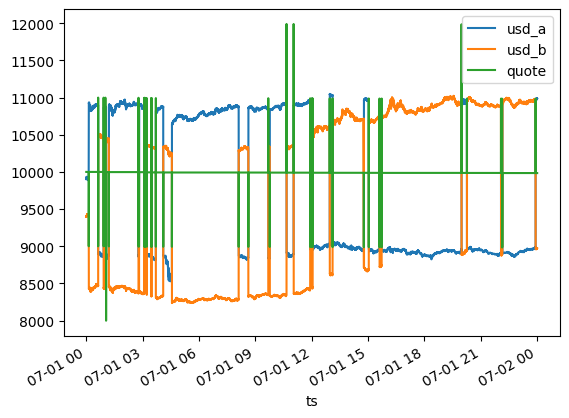

In [22]:
ind[['usd_a', 'usd_b', 'quote']].plot()

<Axes: xlabel='ts'>

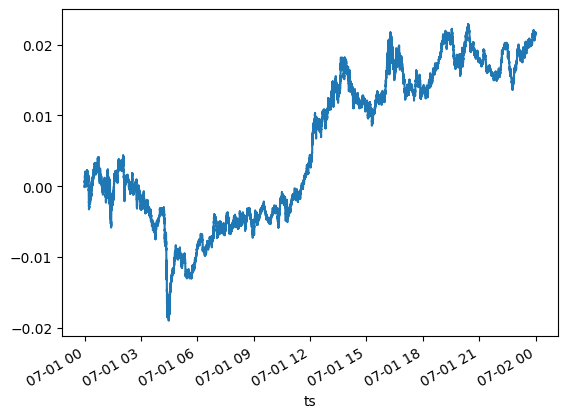

In [24]:
ind.log_bal.cumsum().plot()

<Axes: xlabel='ts'>

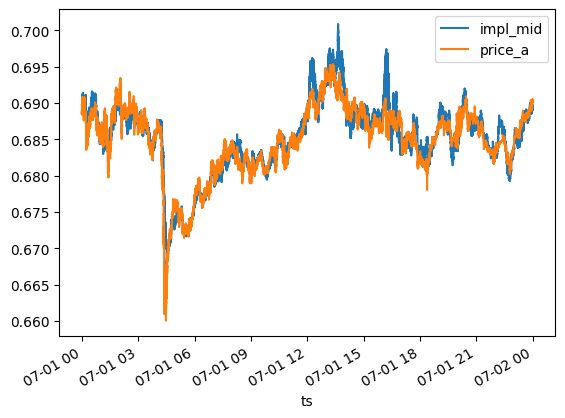

In [31]:
ind[['impl_mid', 'price_a']].plot()

<Axes: xlabel='ts'>

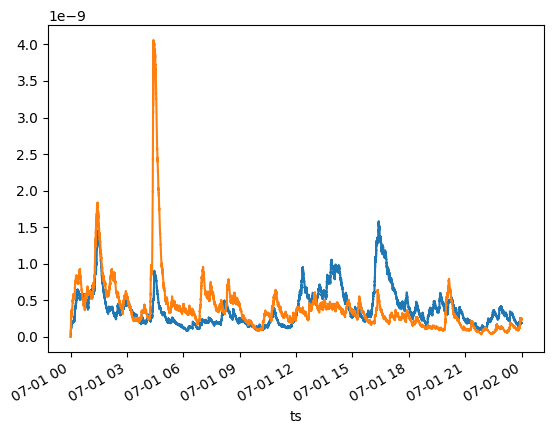

In [25]:
ind.var_b.plot()
ind.var_a.plot()